In [1]:
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), '../../core'))
import kaggle_support as kgs
import importlib
import matplotlib.pyplot as plt
import numpy as np
import cupy as cp
from dataclasses import dataclass, field, fields
import pack_cuda
import pack_vis
import pack_cost
import copy
import time
from IPython.display import HTML, display, clear_output
pack_cuda.USE_FLOAT32 = True
pack_cuda._ensure_initialized()


local
init CUDA
Detected GPU compute capability: 8.9 (arch=sm_89)
GPU max threads per block: 1024
=== Compiling kernel variant: crystal ===
Defines: ENABLE_CRYSTAL_AXES, ENABLE_OVERLAP_AREA, ENABLE_SEPARATION
Command: /usr/local/cuda/bin/nvcc -O3 -use_fast_math --extra-device-vectorization --ptxas-options=-v,--warn-on-spills -arch=sm_89 -DENABLE_CRYSTAL_AXES -DENABLE_OVERLAP_AREA -DENABLE_SEPARATION -cubin /mnt/d//packing/temp/pack_cuda_saved.cu -o /mnt/d//packing/temp/pack_cuda_crystal.cubin
ptxas info    : 0 bytes gmem, 1172 bytes cmem[3]
ptxas info    : Compiling entry function 'multi_boundary_distance_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_distance_list_total
    0 bytes stack frame, 0 bytes spill stores, 0 bytes spill loads
ptxas info    : Used 36 registers, 404 bytes cmem[0], 16 bytes cmem[2]
ptxas info    : Compiling entry function 'multi_boundary_list_total' for 'sm_89'
ptxas info    : Function properties for multi_boundary_list_total
   

In [2]:
%load_ext pyinstrument

In [3]:
#%%pyinstrument
#kgs.profiling=True
# %matplotlib widget
import pack_ga3
import pack_runner
fastMode = False
kgs.debugging_mode = 2 if fastMode else 1

runner_one_nTree = pack_ga3.baseline()
runner_one_nTree.ga.do_legalize = False
runner = copy.deepcopy(runner_one_nTree)

ga_list = []
N_trees_list = [30]
for N_tree in N_trees_list:
    ga_list.append( copy.deepcopy(runner_one_nTree.ga) )
    ga_list[-1].ga_base.N_trees_to_do = N_tree
    ga_list[-1].do_legalize= False
runner.ga = pack_ga3.GAMulti(single_champion=False)
runner.ga.ga_list = ga_list
runner.ga.make_own_fig = (1,1)
runner.ga.make_own_fig_size = (8,8)
runner.ga.best_costs_per_generation_ax = ((0,False,(0,0)),)
runner.diagnostic_plot = True
runner.plot_every = 3
runner.n_generations = 60000 if not fastMode else 3
runner.filename = f'ga_multi_tree_{np.min(N_trees_list)}_to_{np.max(N_trees_list)}'

runner.seed=84


KeyboardInterrupt: 

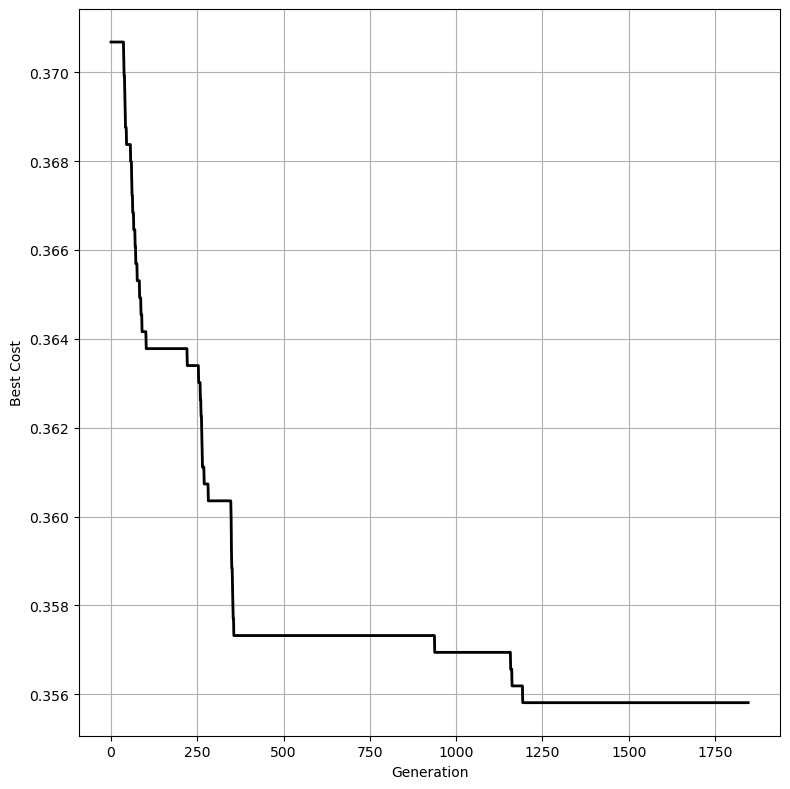

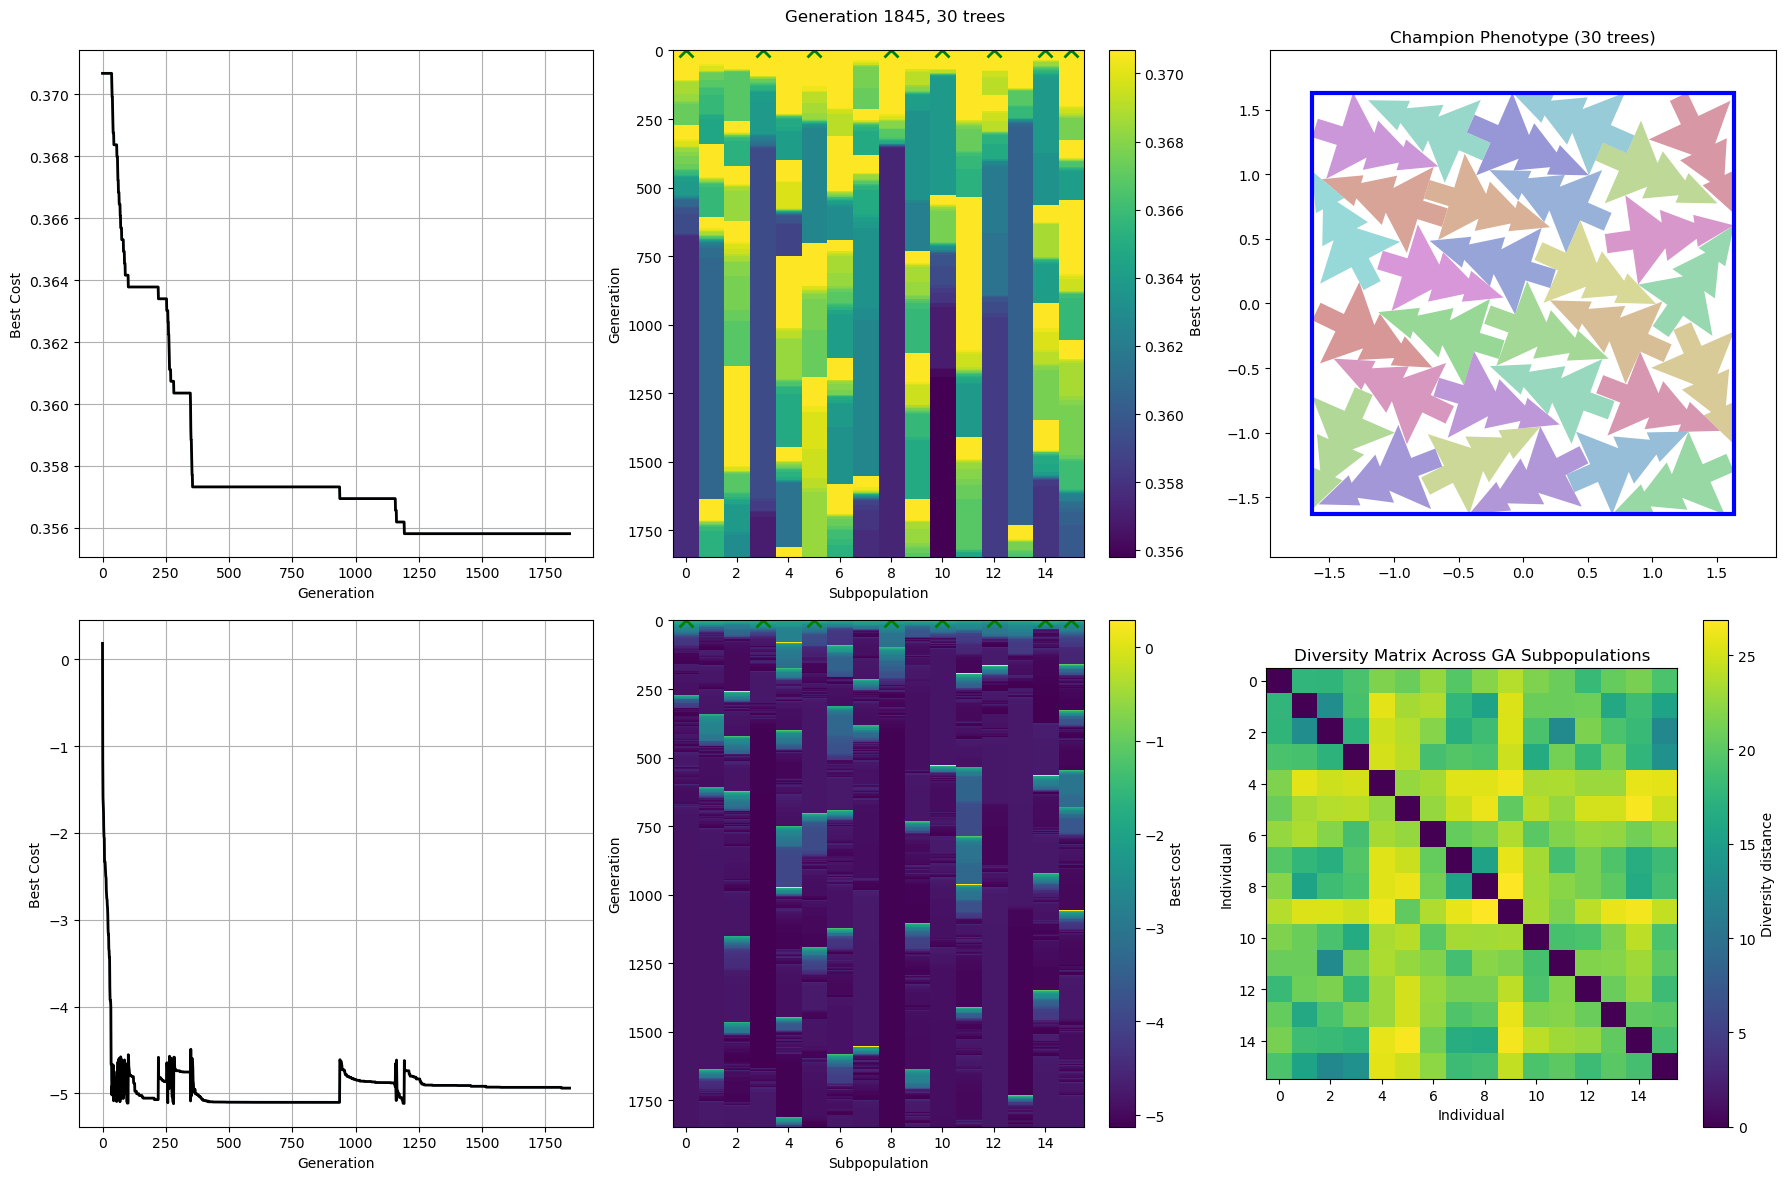

In [4]:
if os.path.isfile(kgs.temp_dir + runner.filename + '.pickle'):
    print("Loading existing runner...")
    runner = kgs.dill_load(kgs.temp_dir + runner.filename + '.pickle')
runner.run()

In [ ]:
rr = kgs.dill_load(kgs.temp_dir + runner.filename + '.pickle')

N=40 best score: [0.37198067 0.02609791]
1
1
1
1


<Figure size 640x480 with 0 Axes>

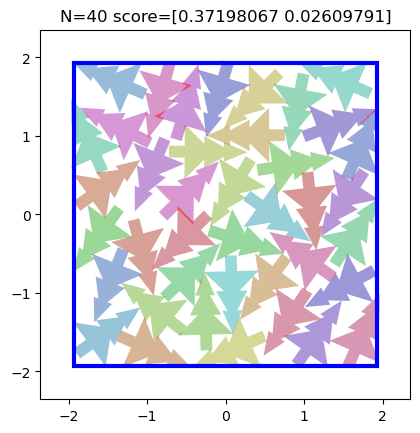

<Figure size 640x480 with 0 Axes>

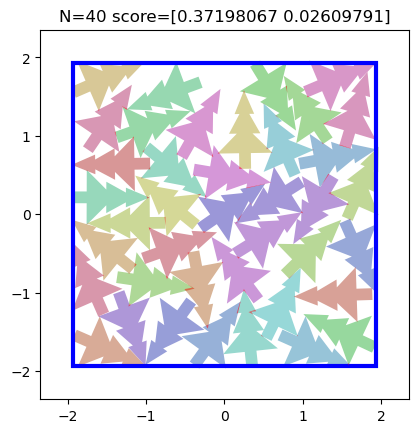

<Figure size 640x480 with 0 Axes>

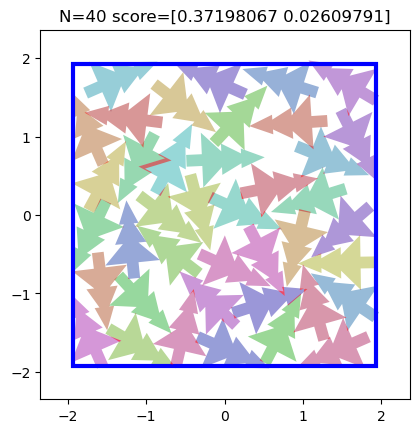

<Figure size 640x480 with 0 Axes>

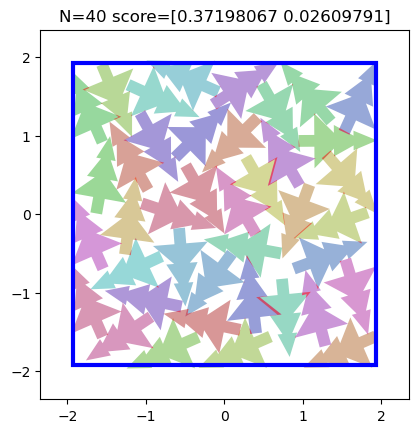

In [ ]:
import pack_vis_sol
#rr.ga.diversity_reset_check_frequency = 1
#for ga in rr.ga.ga_list:
#    ga.diversity_reset_check_frequency = 1
#rr.ga.score(register_best=True) # remove duplicates
for ga in rr.ga.ga_list:
    best_score = ga.champions[-1].fitness[0]
    print(f"N={ga.ga_base.N_trees_to_do} best score: {best_score}")
    ga._fig = None
    ga._ax = None
    #ga.diagnostic_plots(-1,None)
    res = []
    for ga2 in ga.ga_list:        
        if ga2.champions[-1].fitness[0][0] == best_score[0]:
            plt.figure()
            pack_vis_sol.pack_vis_sol(ga2.champions[-1].phenotype)
            plt.title(f"N={ga.ga_base.N_trees_to_do} score={ga2.champions[-1].fitness[0]}")
            res.append(ga2.champions[-1].phenotype)
            print(ga2.champions[-1].phenotype.N_solutions)

In [ ]:
# importlib.reload(kgs)
# rrr=copy.deepcopy(res[0])
# rrr.merge(res[1])
# div_matrix = kgs.compute_genetic_diversity_matrix(rrr.xyt, rrr.xyt)
# div_matrix

In [ ]:
for ga in rr.ga.ga_list:
    ga.do_legalize = True
rr.ga.finalize()

Before optimization:  0.17501766979694366 0.026225406676530838 3.8573601


/mnt/d/packing/code/analysis/runs/../../core/pack_dynamics.py:60: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  x0 = from_dlpack(x0.toDlpack())
/mnt/d/packing/code/analysis/runs/../../core/pack_dynamics.py:92: VisibleDeprecationWarning: This function is deprecated and will be removed in a future release. Use the cupy.from_dlpack() array constructor instead.
  return from_dlpack(tmp_cost[:N].toDlpack()), from_dlpack(res.toDlpack())


After optimization:  0.16066356003284454 0.0007982220267876983 3.9983163
After optimization:  0.1614961475133896 0.00016745011089369655 4.0165744
After optimization:  0.16198132932186127 5.471803524415009e-05 4.0240107
After optimization:  0.16235119104385376 1.4852027561573777e-05 4.0290985
After optimization:  0.16257327795028687 3.4827896797651192e-06 4.0319943
After optimization:  0.162681445479393 8.92940647645446e-07 4.0333676
After optimization:  0.16273397207260132 2.2966366941545857e-07 4.034027
After optimization:  0.16274785995483398 1.4673715043045377e-07 4.0342
After optimization:  0.16276827454566956 5.422162274726361e-08 4.0344543
After optimization:  0.16278815269470215 1.140311134406602e-08 4.0347013
After optimization:  0.16279296576976776 4.848705881244086e-09 4.034761
After optimization:  0.16279615461826324 2.2543431565935634e-09 4.0348005
After optimization:  0.16279952228069305 7.645647448484283e-10 4.0348425
After optimization:  0.16280171275138855 2.68161742811

In [ ]:
# import pack_io
# sol_list = [ga.champions[-1].phenotype for ga in rr.ga.ga_list]
# df = pack_io.solution_list_to_dataframe(sol_list)

In [ ]:
sol_list = [ga.champions[-1].phenotype for ga in rr.ga.ga_list]
kgs.dill_save(kgs.code_dir + f'../res/' + runner.filename + '.pickle', sol_list)

In [ ]:
print(kgs.code_dir + f'../res/' + runner.filename + '.pickle')

/mnt/d//packing/code/core/../res/ga_multi_tree_40_to_40.pickle
